<a id='start'></a>
# Clustering e anomaly detection

In questo notebook vengono presentati degli esercizi sui Decision Tree.

Provate a svolgere il seguente esercizio:<br>
1) [Cluster e elbow method](#section1)<br>
2) [Segmentazione delle specie](#section2)<br>
3) [Chicchi di frumento](#section3)<br>
4) [Vendite ti pesce gatto](#section4)<br>

<a id='section1'></a>
## Cluster e elbow method

Proviamo a predere un dataset con tutti i paesi e la loro latitudine e longitudine e a effettuarne una clusterizzazione:

In [1]:
import pandas as pd
data = pd.read_csv('data/Countries-exercise.csv')
data.head()

name  Longitude   Latitude
0        Aruba -69.982677  12.520880
1  Afghanistan  66.004734  33.835231
2       Angola  17.537368 -12.293361
3     Anguilla -63.064989  18.223959
4      Albania  20.049834  41.142450

In [2]:
data.shape

(241, 3)

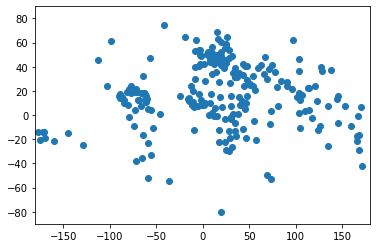

In [3]:
import matplotlib.pyplot as plt

plt.scatter(data['Longitude'], data['Latitude'])
plt.xlim(-180,180)
plt.ylim(-90, 90)
plt.show()

Calcoliamo il numero di cluster da creare con l'elbow method:

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


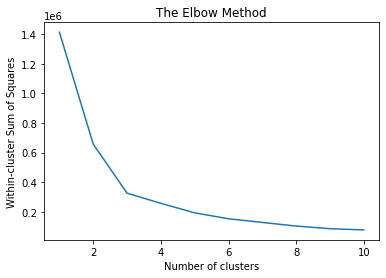

In [4]:
from sklearn.cluster import KMeans

x = data.iloc[:,1:3]
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for.
# Note that 'range' doesn't include the upper boundery
cl_num = 11
number_clusters = range(1, cl_num)

for i in number_clusters:
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    

plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

Il numero ottimale di cluster sembra essere 3, procediamo quindi alla clusterizzazione:

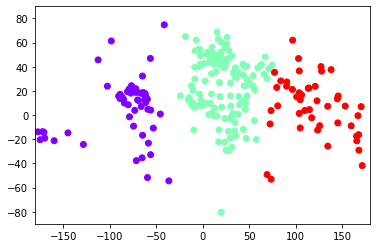

In [5]:
kmeans = KMeans(3)
kmeans.fit(x)

identified_clusters = kmeans.fit_predict(x)
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = identified_clusters

plt.scatter(data['Longitude'], data['Latitude'], c=data_with_clusters['Cluster'], cmap='rainbow')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()

Come si vede, molte isole pacifiche dell'oceania sono catalogate nel cluster insieme alle americhe. Questo avviene perchè nel nostro modello le coordinate non sono considerate come "circolari" e quindi -180 è molto lontano da +179, che invece sappiamo essere vicini.

Per ovviare a questo problema proviamo a fare un meccanismo di "ensamble" unendo diversi modelli, ciascuno con una tralazione delle coordinate di longitudine. Al termine dell'esecuzione di tutti i modelli assegniamo ogni elemento al cluster in cui più frequentemente è stato assegnato.

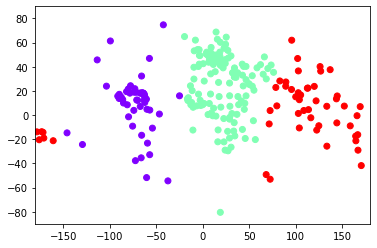

In [6]:
from statistics import mode

# Facciamo un ciclo per calcolare una traslazione delle longitudini tra -180 e +180
computed_vals = []
for t in range(-180, 180):
    kmeans = KMeans(3)
    
    # Trasformo nel dataset le longitudini con la traslazione specificata dall'iterazione
    d = data[['Longitude', 'Latitude']].copy()
    longs = d['Longitude'].values
    longs = [(l + t) % 360 - 180 for l in longs]
    d['Longitude'] = longs
    
    # Calcolo i cluster e recupero i centroidi, con questo metodo cerco di numerare sempre allo stesso modo i
    # cluster creati (partendo da zero in avanti da quello con longitudine minore a quello con longitudine maggiore)
    clusters = kmeans.fit_predict(d)
    centroids_lat = [(x[0] - t) % 360 - 180 for x in kmeans.cluster_centers_]
    centroids_lat_sorted = sorted(centroids_lat)

    centroid_mapping = {}
    for i in range(len(centroids_lat)):
        centroid_mapping[i] = centroids_lat_sorted.index(centroids_lat[i])
        
    # Aggiungo a una mia lista i valori (rinormalizzati) dei cluster stimati
    clusters = list(map(lambda x: centroid_mapping[x], clusters))
    computed_vals.append(clusters)
    
# Calcolo la moda dei cluster computati per ogni elemento nel mio dataset
clusters = []
for i in range(len(data[['Longitude', 'Latitude']].values)):
    vals = [c[i] for c in computed_vals]
    clusters.append(mode(vals))

# Grafico i risultati
plt.scatter(d['Longitude'], d['Latitude'], c=clusters, cmap='rainbow')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.show()


<a id='section2'></a>
## Segmentazione delle specie

Per questo esercizio utilizzeremo l'Iris flower dataset, che è uno dei dataset più popolari per gli esercizi di machine learning. Puoi leggere molte informazioni a riguardo a questo link: https://en.wikipedia.org/wiki/Iris_flower_data_set

In questo dataset ci sono 4 feature: sepal length, sepal width, petal length, and petal width.

Prova a disegnare i dati con 2, 3 e 5 cluster. Cosa osservi?

Prova a identificare il numero ottimale di cluster e poi calcolalo col metodo elbow.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

data = pd.read_csv('data/iris-dataset.csv')
data.head()

sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

Visualizziamo i dati:

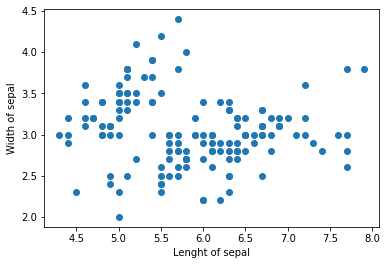

In [8]:
# Create a scatter plot based on two corresponding features (sepal_length and sepal_width; OR petal_length and petal_width)
plt.scatter(data['sepal_length'], data['sepal_width'])
# Name your axes
plt.xlabel('Lenght of sepal')
plt.ylabel('Width of sepal')
plt.show()

Riscaliamo i dati in modo da avere clusterizzazioni più precise:

In [9]:
# import some preprocessing module
from sklearn import preprocessing

# scale the data for better results
x_scaled = preprocessing.scale(data)
x_scaled[:10]

array([[-0.90068117,  1.03205722, -1.3412724 , -1.31297673],
       [-1.14301691, -0.1249576 , -1.3412724 , -1.31297673],
       [-1.38535265,  0.33784833, -1.39813811, -1.31297673],
       [-1.50652052,  0.10644536, -1.2844067 , -1.31297673],
       [-1.02184904,  1.26346019, -1.3412724 , -1.31297673],
       [-0.53717756,  1.95766909, -1.17067529, -1.05003079],
       [-1.50652052,  0.80065426, -1.3412724 , -1.18150376],
       [-1.02184904,  0.80065426, -1.2844067 , -1.31297673],
       [-1.74885626, -0.35636057, -1.3412724 , -1.31297673],
       [-1.14301691,  0.10644536, -1.2844067 , -1.4444497 ]])

Clustering con 2 gruppi:

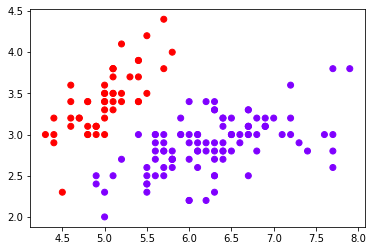

In [10]:
kmeans_2 = KMeans(2)
x = data.copy()
kmeans_2.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_2 = data.copy()
clusters_2['cluster_pred'] = kmeans_2.fit_predict(x_scaled)
plt.scatter(clusters_2['sepal_length'], clusters_2['sepal_width'], c=clusters_2['cluster_pred'], cmap='rainbow')
plt.show()

Clustering con 3 gruppi:

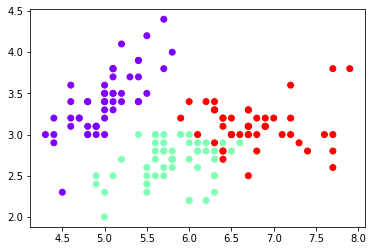

In [11]:
kmeans_3 = KMeans(3)
kmeans_3.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_3 = data.copy()
clusters_3['cluster_pred'] = kmeans_3.fit_predict(x_scaled)
plt.scatter(clusters_3['sepal_length'], clusters_3['sepal_width'], c=clusters_3['cluster_pred'], cmap='rainbow')
plt.show()

Clustering con 5 gruppi:

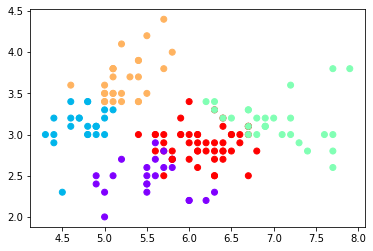

In [12]:
kmeans_5 = KMeans(5)
kmeans_5.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_5 = data.copy()
clusters_5['cluster_pred'] = kmeans_5.fit_predict(x_scaled)
plt.scatter(clusters_5['sepal_length'], clusters_5['sepal_width'], c=clusters_5['cluster_pred'], cmap='rainbow')
plt.show()

Eseguiamo ora il metodo elbow:

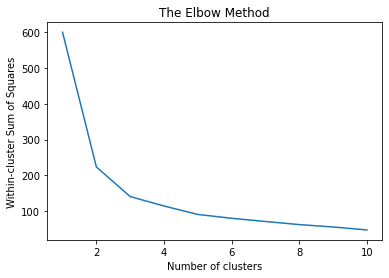

In [13]:
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for.
# Note that 'range' doesn't include the upper boundery
cl_num = 11
for i in range (1, cl_num):
    kmeans = KMeans(i)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

Per calcolare il numero di cluster da creare in una clusterizzazione, possiamo usare un metodo detto silhouette.

L'analisi silhouette può essere utilizzata per studiare la distanza di separazione tra i cluster. Il grafico della "sagoma" mostra una misura della vicinanza di ciascun punto in un cluster ai punti dei cluster vicini e fornisce quindi un modo per valutare visivamente i parametri come il numero di cluster. Questa misura ha un intervallo di \[-1, 1\].

I coefficienti silhouette (come vengono chiamati questi valori) vicino a +1 indicano che il campione è lontano dai cluster vicini. Un valore 0 indica che il campione molto vicino al limite di decisione tra due cluster adiacenti e valori negativi indicano che tali campioni potrebbero essere stati assegnati al cluster sbagliato.

For n_clusters = 2 The average silhouette_score is : 0.580184463257396
For n_clusters = 3 The average silhouette_score is : 0.4589717867018717
For n_clusters = 4 The average silhouette_score is : 0.3882779720919106
For n_clusters = 5 The average silhouette_score is : 0.3516422319268987
For n_clusters = 6 The average silhouette_score is : 0.32800245312290494


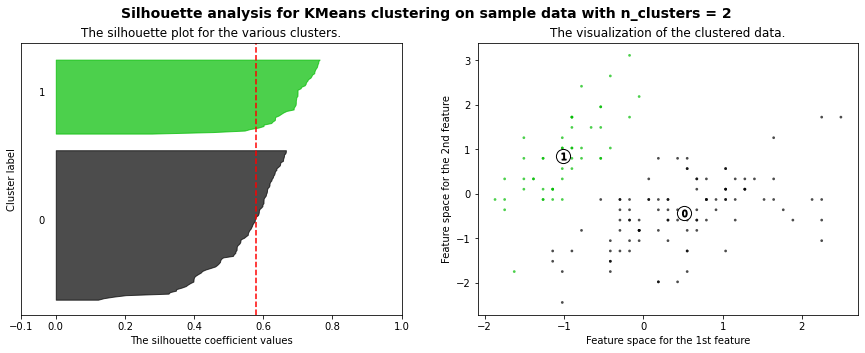

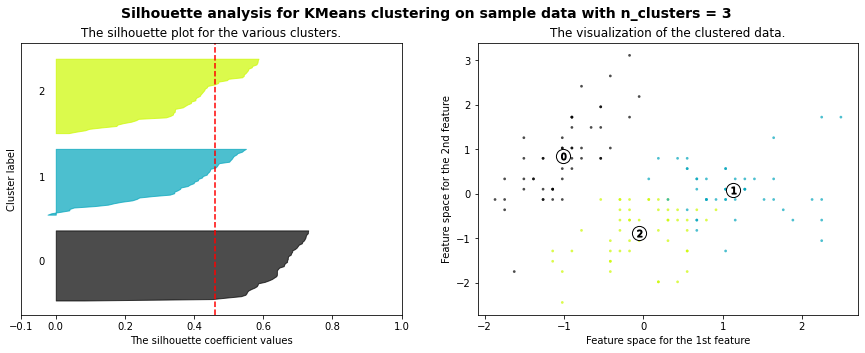

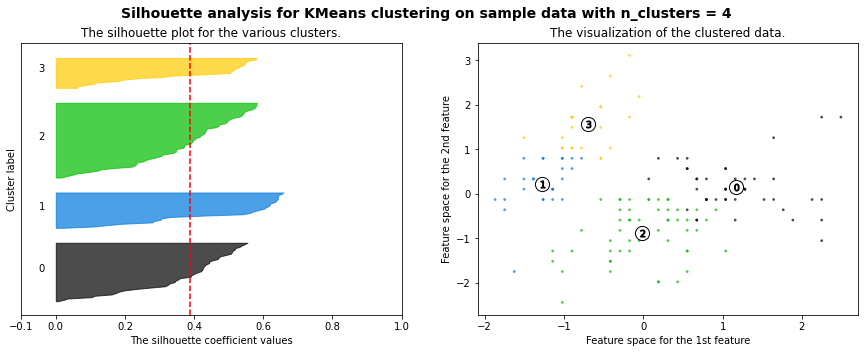

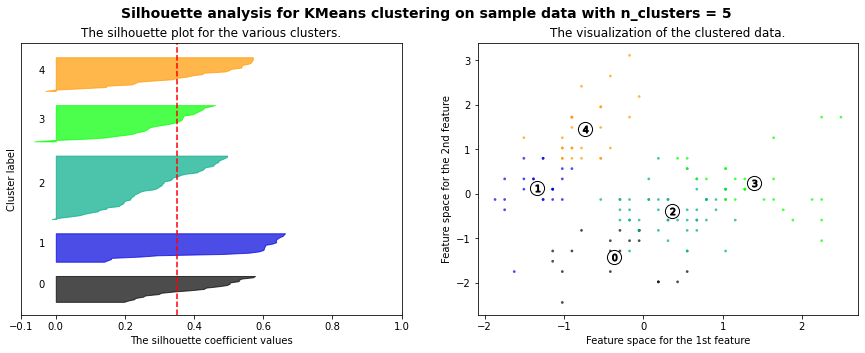

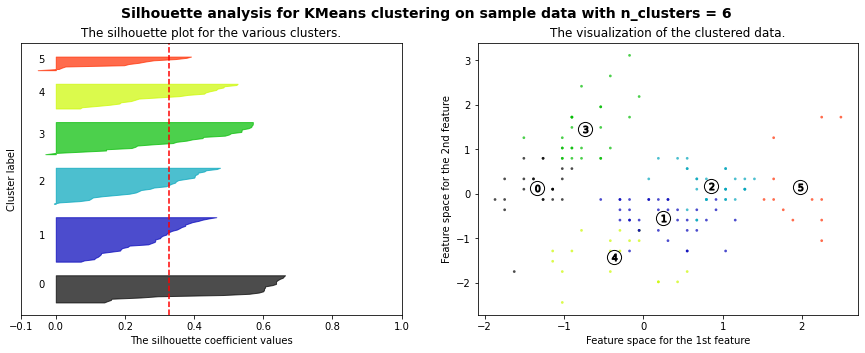

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters)
    cluster_labels = clusterer.fit_predict(x_scaled)
    
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    sample_silhouette_values = silhouette_samples(x_scaled, cluster_labels)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_scaled) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_scaled[:, 0], x_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

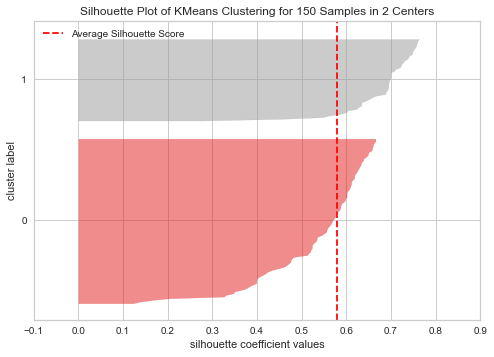

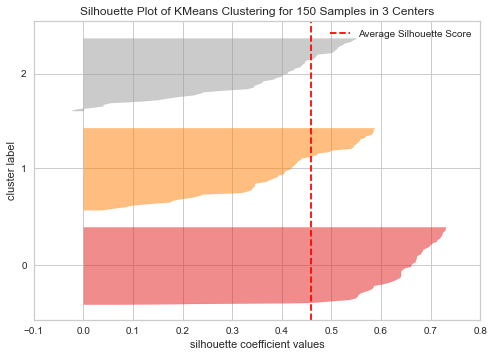

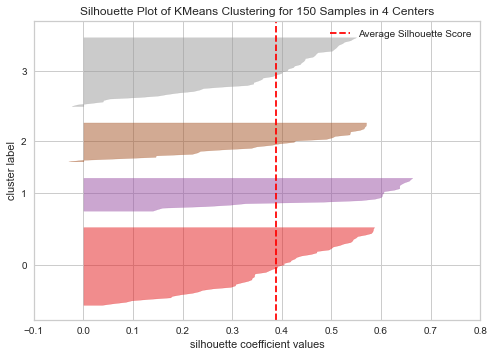

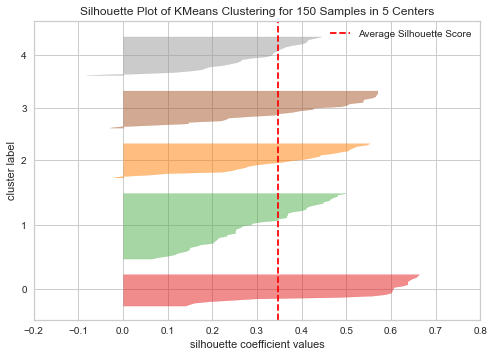

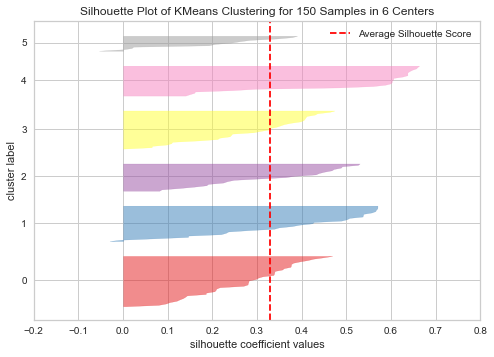

In [15]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    model = SilhouetteVisualizer(KMeans(n_clusters))
    model.fit(x_scaled)
    model.show()

Guardando questi grafici (sia visivamente che controllando i valori numerici associati):
- con 2 cluster, la dimensione dei cluster varia (il cluster 0 ha molte più osservazioni del cluster 1).
- con 3 cluster, la dimensione di ogni claster è abbastanza omogenea, quasi nessuna osservazione è assegnata al cluster errato e tutti i cluster hanno osservazioni che sono più della media dello score silhouette.
- con 4, 5 o 6 cluster, i cluster non sono più particolarmente omogenei, più osservazioni hanno valori di silhouette negativi (quindi che indicano essere stati classificati erroneamente)

Questo implica che il metodo Silhouette suggerisce che 3 sia il numero ottimale di cluster da creare.

Il numero di cluster corretto, con entrambi i metodo, quindi sembra essere 3:

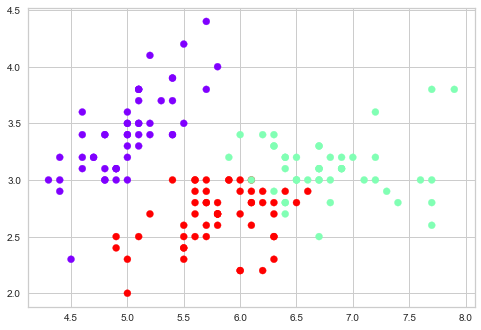

In [16]:
kmeans_3 = KMeans(3)
kmeans_3.fit(x_scaled)

# Remember that we are plotting the non-standardized values of the sepal length and width. 
clusters_3 = data.copy()
clusters_3['cluster_pred'] = kmeans_3.fit_predict(x_scaled)
plt.scatter(clusters_3['sepal_length'], clusters_3['sepal_width'], c=clusters_3['cluster_pred'], cmap='rainbow')
plt.show()

Se proviamo a leggere un altro dataset, che vi fornisco apposta, chiamato iris-with-answers.csv, vedrete che effettivamente 3 è il numero delle specie di iris contenute nel dataset.

In [17]:
real_data = pd.read_csv('data/iris-with-answers.csv')
real_data['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

Il plot di questi dati è molto simile a quello calcolato dal nostro modello e sembra molto confuso:

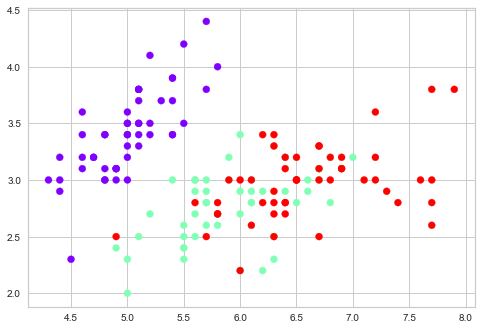

In [18]:
# We use the map function to change any 'yes' values to 1 and 'no'values to 0. 
real_data['species'] = real_data['species'].map({'setosa': 0, 'versicolor': 1 , 'virginica': 2})

plt.scatter(real_data['sepal_length'], real_data['sepal_width'], c=real_data['species'], cmap='rainbow')

Ma se invece che il sepalo, guardassi i petali?

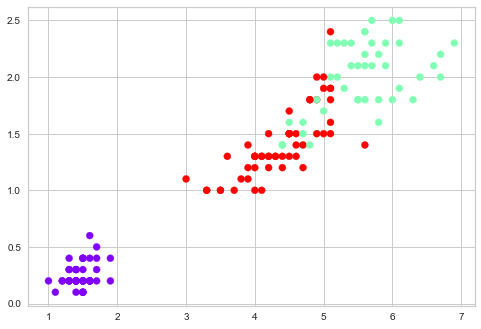

In [21]:
plt.scatter(clusters_3['petal_length'], clusters_3['petal_width'], c=clusters_3['cluster_pred'], cmap='rainbow')
plt.show()

<a id='section3'></a>
## Chicchi di frumento

Leggiamo il dataset che contiene misurazioni delle proprietà geometriche di chicchi appartenenti a tre diverse varietà di frumento. Una tecnica a raggi X morbidi e un pacchetto GRAINS sono stati utilizzati per costruire tutti e sette gli attributi a valore reale.

Proviamo a clusterizzare questo dataset con i 2 metodi visti: KMeans e DBScan.

In [36]:
import pandas as pd
import numpy as np

dataframe = pd.read_csv('data/seeds_dataset.txt',
                        header = None, 
                        sep = "\t",
                        on_bad_lines='skip', 
                        usecols = range(7)
                       )

dataframe.columns = ["AREA", "PERIMETER", "COMPACTNESS", "LENGTH", "WIDTH", "ASYMMETRY", "GROOVE_LENGTH"] 

dataframe.head()

AREA  PERIMETER  COMPACTNESS  LENGTH  WIDTH  ASYMMETRY  GROOVE_LENGTH
0  15.26      14.84       0.8710   5.763  3.312      2.221          5.220
1  14.88      14.57       0.8811   5.554  3.333      1.018          4.956
2  14.29      14.09       0.9050   5.291  3.337      2.699          4.825
3  13.84      13.94       0.8955   5.324  3.379      2.259          4.805
4  16.14      14.99       0.9034   5.658  3.562      1.355          5.175

Proseguiamo ora a fare un clustering con DBscan:

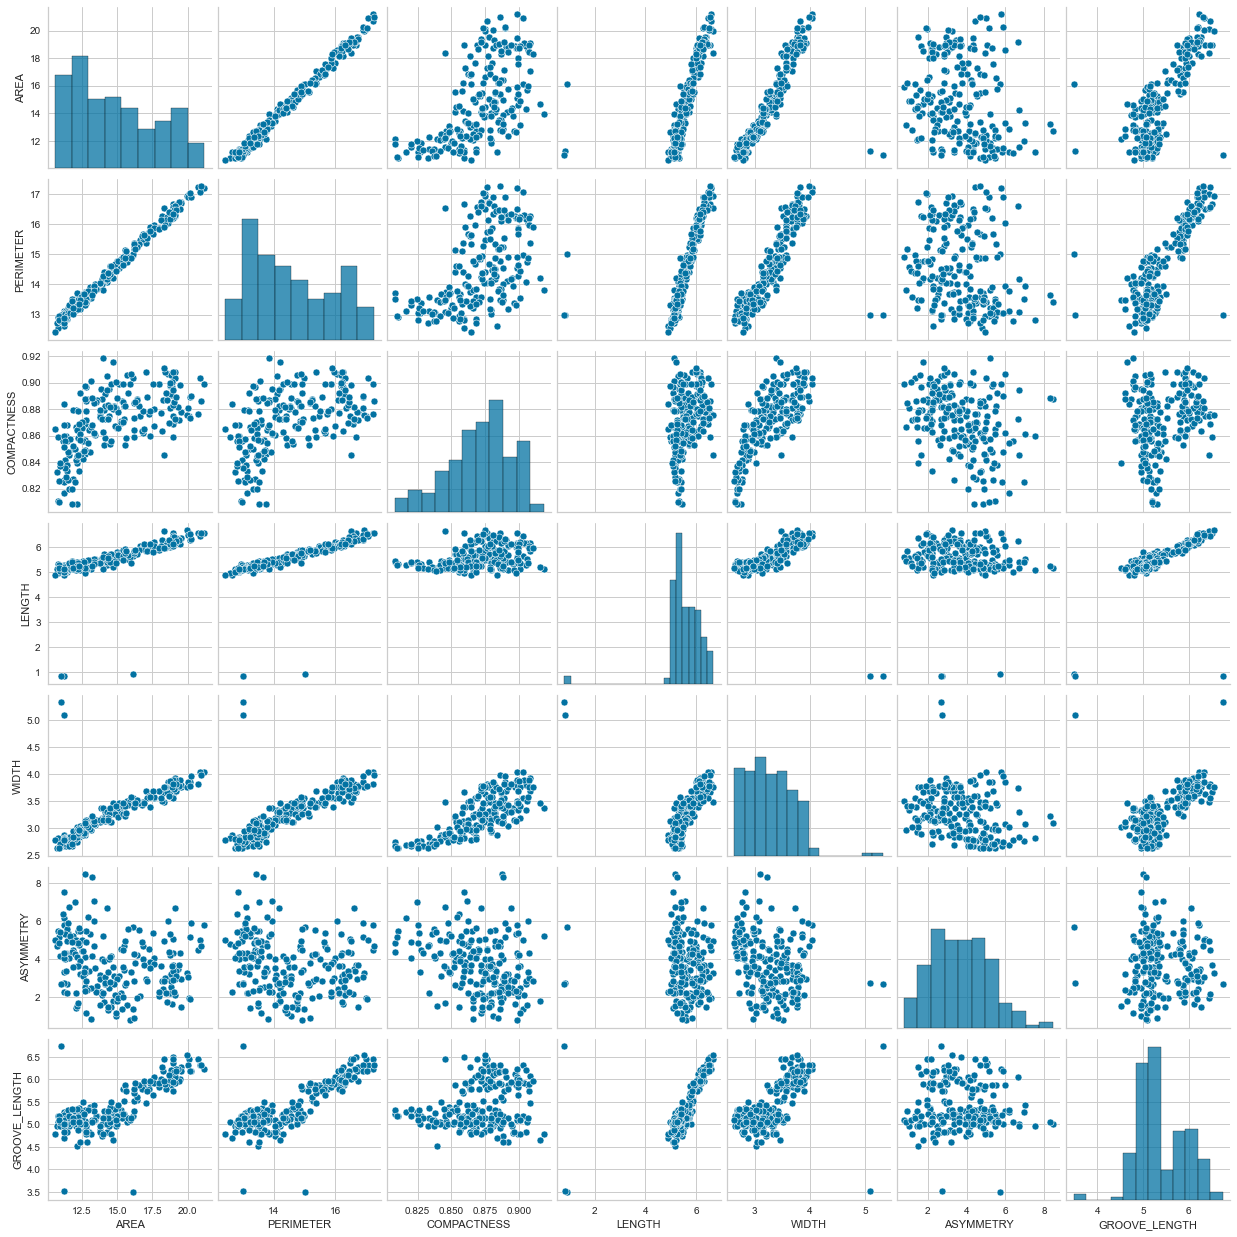

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(dataframe, palette="Accent")
plt.show()

In [38]:
from sklearn.preprocessing import StandardScaler
cleaned_dataframe = dataframe.dropna()

scaler = StandardScaler()
scaled_array = scaler.fit_transform(cleaned_dataframe)
scaled_dataframe = pd.DataFrame(scaled_array, columns=dataframe.columns)

Eseguiamo il clustering con KMeans:

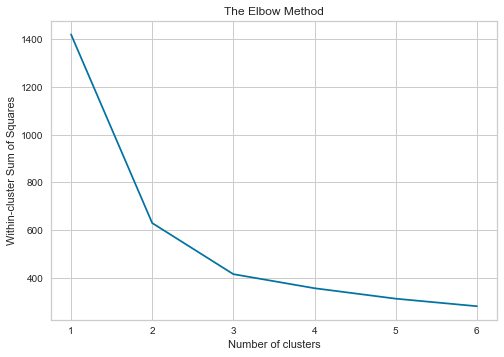

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss=[]

# Create all possible cluster solutions with a loop
for i in range(1,7):
    # Cluster solution with i clusters
    kmeans = KMeans(i)
    # Fit the data
    kmeans.fit(scaled_dataframe)
    # Find WCSS for the current iteration
    wcss_iter = kmeans.inertia_
    # Append the value to the WCSS list
    wcss.append(wcss_iter)
    
number_clusters = range(1,7)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
plt.show()

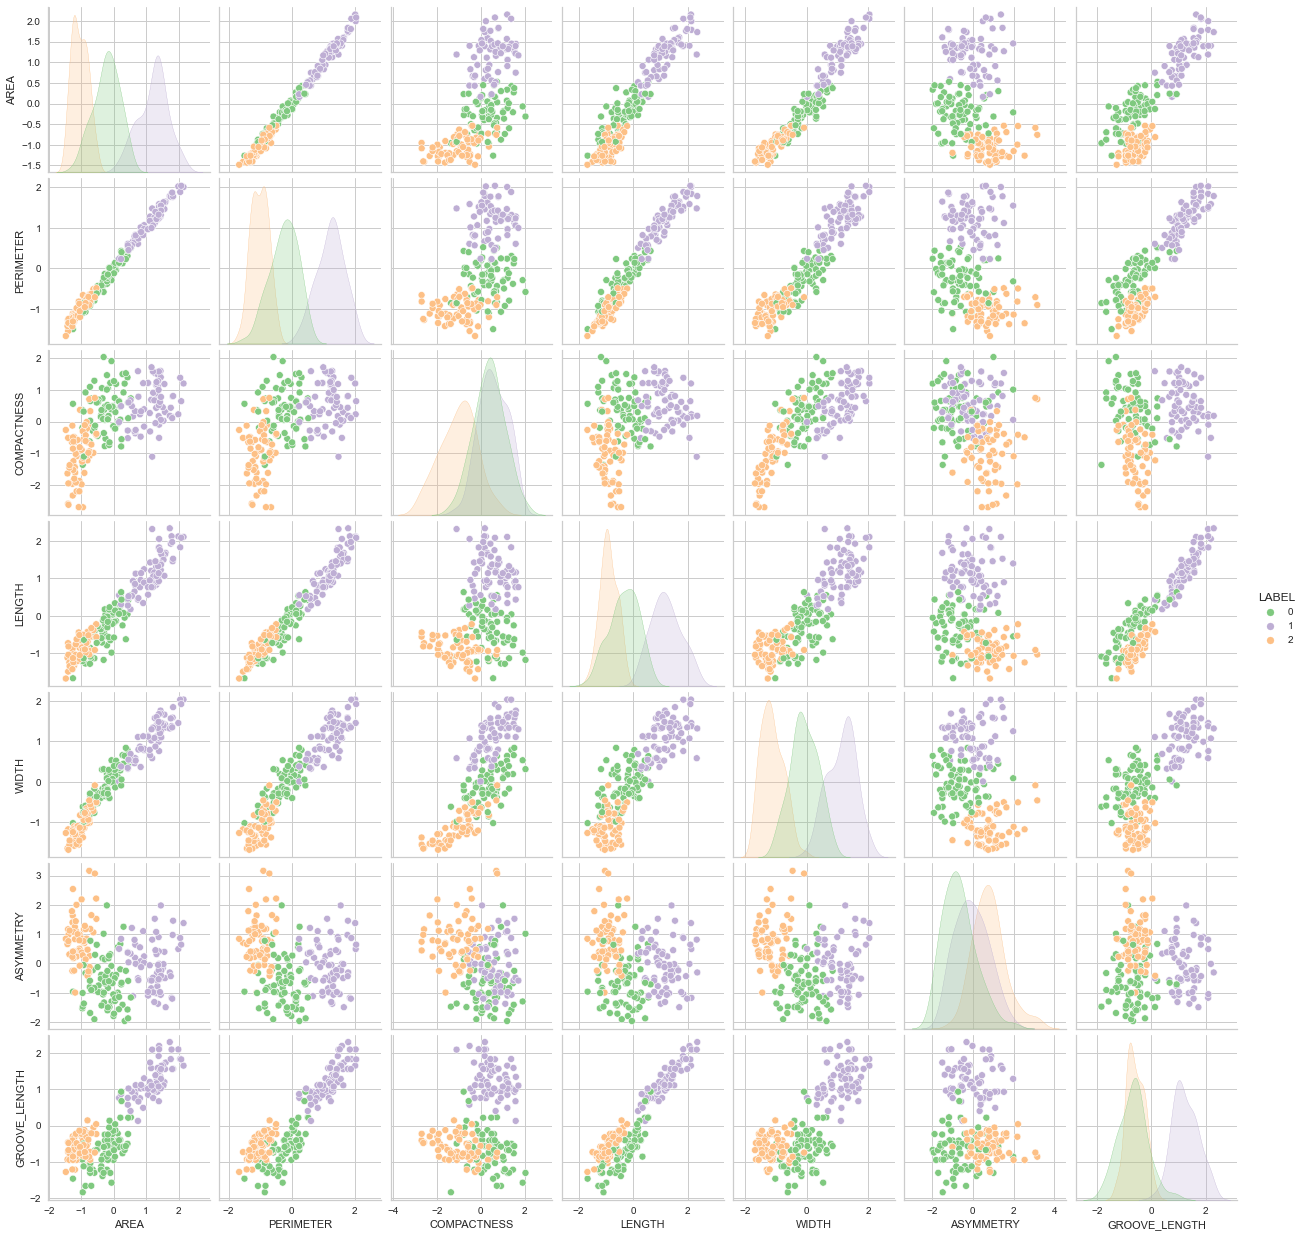

In [40]:
kmeans = KMeans(3)
kmeans.fit(scaled_dataframe)
identified_clusters = kmeans.fit_predict(scaled_dataframe)

centroids = kmeans.cluster_centers_

df = scaled_dataframe.copy()
df["LABEL"] = identified_clusters
sns.pairplot(df, hue="LABEL", palette="Accent")
plt.show()

Per confrontare i cluster creati con questo metodo rispetto al successivo, utilizzeremo il WSS e il BSS. Creiamo due funzioni per calcolarli.

In [41]:
from sklearn.metrics.pairwise import euclidean_distances

def compute_wss(dataframe, clusters):
    df = dataframe.copy()
    df['cluster'] = clusters
    
    wss = 0
    for clust in np.unique(df['cluster']):
        sub_df = df[df['cluster'] == clust]
        
        for el in df.to_numpy():
            dist = euclidean_distances(
                el.reshape(1, -1),
                sub_df.mean().to_numpy().reshape(1, -1))
            wss += dist**2
        
    return wss[0][0]

def compute_bss(dataframe, clusters):
    df = dataframe.copy()
    df['cluster'] = clusters
    
    bss = 0
    for clust in np.unique(df['cluster']):
        sub_df = df[df['cluster'] == clust]
        
        for el in df.to_numpy():
            dist = euclidean_distances(
                df.mean().to_numpy().reshape(1, -1), 
                sub_df.mean().to_numpy().reshape(1, -1))
            bss += dist**2
        
    return bss[0][0]

Calcoliamo ora i valori per questo clustering:

In [42]:
wss = compute_wss(scaled_dataframe, identified_clusters)
bss = compute_bss(scaled_dataframe, identified_clusters)

print(f'WSS = {wss:.2f}, BSS = {bss:.2f}')

WSS = 8155.65, BSS = 3488.84


Ora proviamo a fare lo stesso usando DBscan:

1.073406888266603


<Figure size 360x360 with 0 Axes>

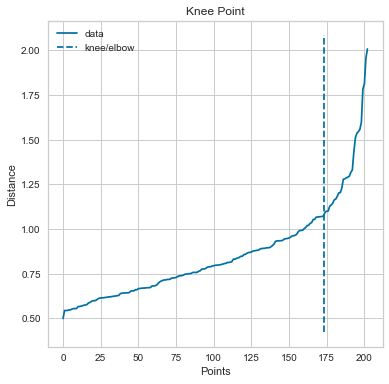

In [43]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 5
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(scaled_dataframe)

distances, indices = neighbors.kneighbors(scaled_dataframe)
distances = np.sort(distances[:,n_neighbors-1], axis=0)

from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

eps = distances[knee.knee]
print(eps)

/var/folders/fy/5ftynfvs4r5c5z37g3c9nw780000gn/T/ipykernel_94634/284911506.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataframe["LABEL"] = labels


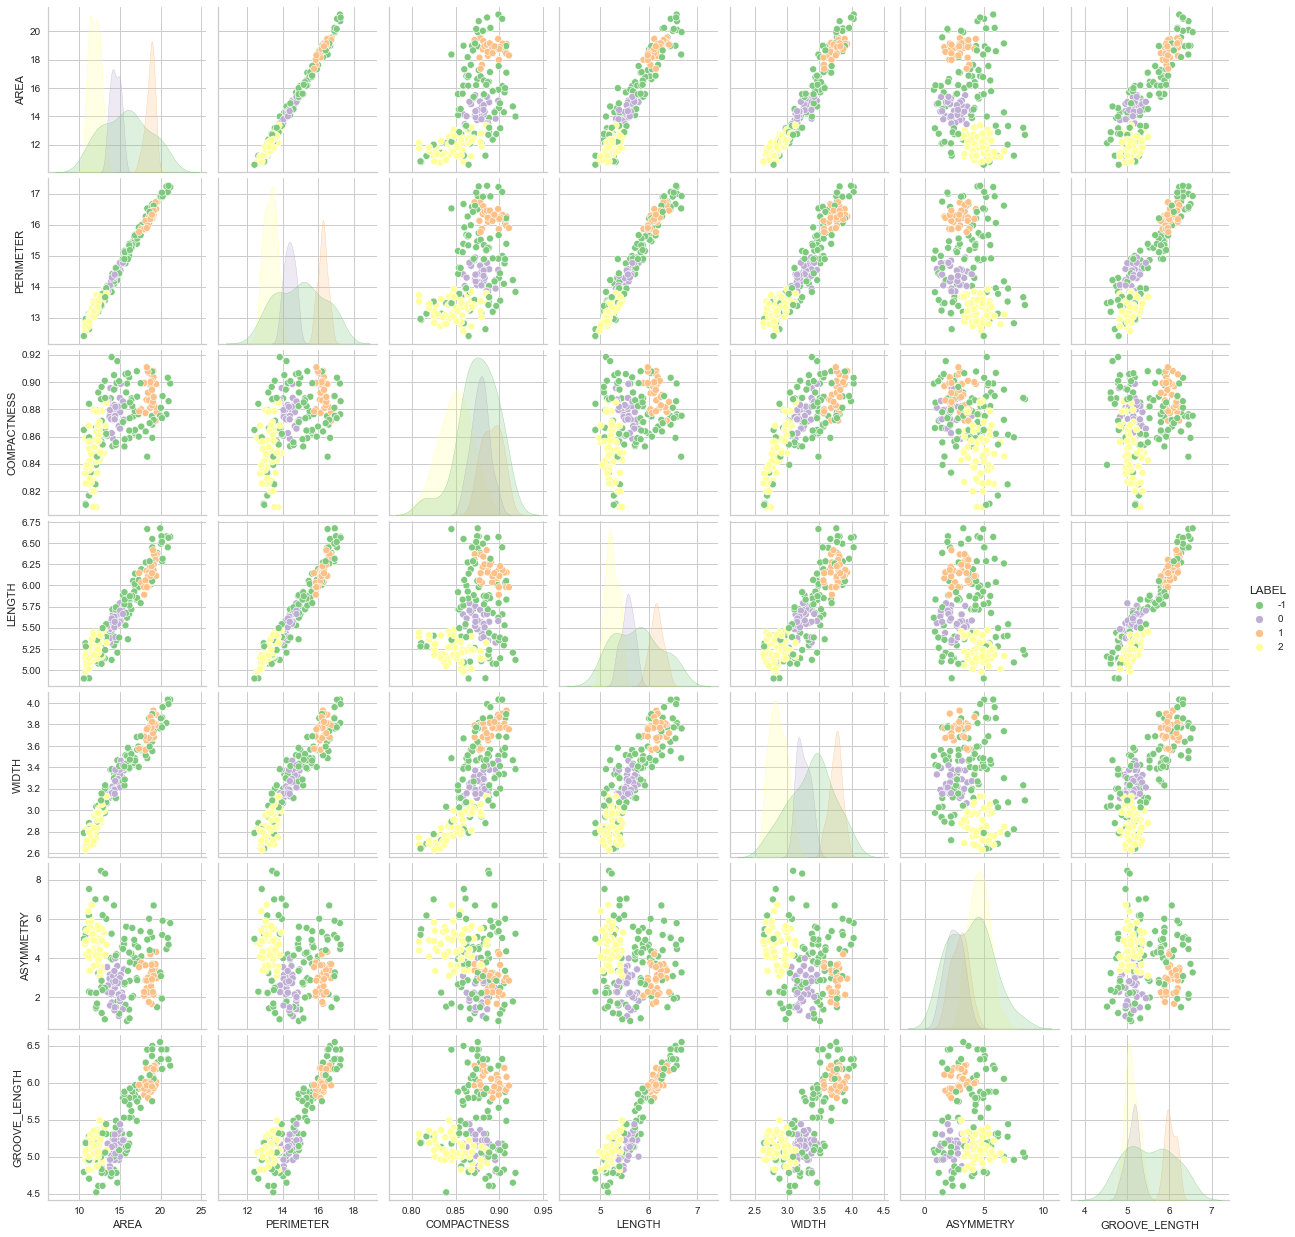

Estimated no. of clusters: 3
Estimated no. of noise points: 85


In [44]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import v_measure_score

dbscan_model = DBSCAN(eps=eps, min_samples=20)
dbscan_model.fit(scaled_dataframe)
labels = dbscan_model.labels_

cleaned_dataframe["LABEL"] = labels
sns.pairplot(cleaned_dataframe, hue="LABEL", palette="Accent")
plt.show()

# Number of Clusters
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(labels).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

Calcoliamo ora WSS e BSS usando le funzioni definite sopra:

In [45]:
wss = compute_wss(cleaned_dataframe, labels)
bss = compute_bss(cleaned_dataframe, labels)

print(f'WSS = {wss:.2f}, BSS = {bss:.2f}')

WSS = 22042.38, BSS = 8886.90


<a id='section4'></a>
## Vendite di pesce gatto

Importiamo il set di dati contenente le vendite di pesce gatto dal 1986 al 2001.
Usiamo quindi degli algoritmi per identificare eventuali anomalie nelle vendite.

In [2]:
import pandas as pd
dataset = pd.read_csv('data/catfish_sales_1986_2001.csv', parse_dates=[0])

# Reindexing dataframe
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
period_index = pd.PeriodIndex(datetime_index, freq='M')
dataset = dataset.set_index(period_index)
dataset.drop('Date', axis=1, inplace=True)

dataset

Total
1986-01   9034
1986-02   9596
1986-03  10558
1986-04   9002
1986-05   9239
...        ...
2012-08  14442
2012-09  34722
2012-10  13795
2012-11  13352
2012-12  12716

[324 rows x 1 columns]

In [3]:
import plotly.express as px
fig = px.box(dataset, y="Total", title='Catfish sales 1986-2000')
fig.show()

In [35]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

clf = IsolationForest(max_samples='auto', contamination=0.01)
dataset['Anomaly IF'] = clf.fit_predict(dataset)


lf = LocalOutlierFactor(n_neighbors=10)
dataset['Anomaly LOF'] = clf.fit_predict(dataset)

anomalies = dataset[(dataset['Anomaly IF'] == -1) | (dataset['Anomaly LOF'] == -1)]
anomalies

Total  Anomaly IF  Anomaly LOF
1986-12   8196          -1           -1
2011-07   1229          -1           -1
2012-03  44717          -1           -1
2012-09  34722          -1           -1

In [36]:
import plotly.graph_objects as go

b1 = go.Scatter(x=dataset.index.astype(str),
                y=dataset['Total'],
                name="Dataset",
                mode='markers'
               )
b2 = go.Scatter(x=anomalies.index.astype(str),
                y=anomalies['Total'],
                name="Anomalies",
                mode='markers',
                marker=dict(color='red', size=6,
                            line=dict(color='red', width=1))
               )

layout = go.Layout(
    title="Isolation Forest results",
    yaxis_title='Sales',
    xaxis_title='Date',
    hovermode='closest'
)

data = [b1, b2]

fig = go.Figure(data=data, layout=layout)
fig.show()

[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>